In [1]:
import pandas as pd
from model import Brain
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from jf.db import DB
from lib.plot import plot_2d_positions_colors
from lib.sde.grn import GRNMain
from lib.sde.mutate import mutate_grn

In [2]:
"""
Just need to finalize the mutation
Then we shall be close to first running
"""

'\nJust need to finalize the mutation\nThen we shall be close to first running\n'

In [3]:
from itertools import accumulate
import numpy as np

In [4]:
END_TIME = 65

In [5]:
HALL_OF_FAME = []

In [6]:
REF = pd.read_csv("output/results/setup_basic/export/ref_basic.csv")  # ref is a mean

In [7]:
def individual_generator():
    return Solution(GRNMain(5, 0, 5))

In [8]:
if False:
    grn = GRNMain(5, 0, 5)
    ccls = factories["grn1"](grn=grn)

    bb = Brain(time_step=0.5, verbose=False, start_population=4, max_pop_size=1e3,
            cell_cls=ccls.generate, end_time=60, start_time=50, silent=True)
    bb.run()

In [9]:
def r():
    return np.random.uniform(0, 1)

class Solution:
    def __init__(self, grn):
        self.grn = grn
        
    def copy(self):
        return Solution(self.grn.copy())
        
    def mutate(self):
        mutate_grn(self.grn)

In [10]:
individual_generator().grn

>> G_0: b: 6.62; m: 7.26; deg: 5.89; expr: 6.67; thr: 6.99; theta: 5.57; tree : (0 AND (2 OR 3))
>> G_1: b: 7.58; m: 8.03; deg: 9.30; expr: 5.67; thr: 5.36; theta: 3.82; tree : NOT 2
>> G_2: b: 2.70; m: 1.80; deg: 7.40; expr: 5.24; thr: 3.17; theta: 9.82; tree : 2
>> G_3: b: 6.27; m: 6.98; deg: 6.47; expr: 8.36; thr: 5.38; theta: 1.47; tree : 3
>> G_4: b: 2.67; m: 8.43; deg: 9.76; expr: 7.41; thr: 3.16; theta: 4.05; tree : (0 AND 3)

In [11]:
def shrink_and_align_stats(stats, ref, max_step=None):
    min_step = max(min(stats.time), min(ref.time))
    if max_step is None:
        max_step = max(ref.time)
    
    new_stats = stats[(stats.time >= min_step) & (stats.time <= max_step)].set_index("time")
    new_ref = ref[(ref.time >= min_step) & (ref.time <= max_step)].set_index("time")
    
    return new_stats, new_ref

In [12]:
# compare only the progenitor_pop_size
def evaluating_function(stats, ref, max_step=None):
    """
    The evaluation function for progenitor population size.
    The lower is the better
    :param stats: the stats of the bb after running
    """
    colname_ref = "size_type_Cycling"
    colname_stats = "progenitor_pop_size"
    # scale
    stats, ref = shrink_and_align_stats(stats, ref, max_step=max_step)
    
    min_step = min(ref.index)  # ref.index is the time
    stats[colname_stats] = stats[colname_stats] / stats[colname_stats].get(min_step)
    ref[colname_ref] = ref[colname_ref] / ref[colname_ref].get(min_step)
    
    err = 0
    for t in ref.index:
        val_ref = ref[colname_ref].get(t, 0)
        val_stats = stats[colname_stats].get(t, 0)
        err += (val_ref - val_stats)**2 / val_ref
        
    return err

In [13]:
def run_grn(grn):
    ccls = factories["grn1"](grn=grn)
    bb = Brain(time_step=0.5, verbose=False, start_population=4, max_pop_size=1e3,
            cell_cls=ccls.generate, end_time=END_TIME, start_time=50, silent=True)
    bb.run()
    return bb

In [14]:
def fitness_func(grn):
    bb = run_grn(grn)
    output = evaluating_function(bb.stats, REF, max_step=END_TIME)
    fitness = 1.0 / output
    return fitness

In [15]:
# generation
POP_SIZE = 30
N_GEN = 30
def do_init_pop():
    return [individual_generator() for i in range(POP_SIZE)]

def do_fitness(pop):
    return [fitness_func(sol.grn) for sol in pop]

def do_selection(pop_fit, pop):
    # print("Fit score : ", pop_fit)
    pop_sel = []
    acc = list(accumulate(pop_fit))
    best = max(pop_fit)
    best_sol = pop[pop_fit.index(best)]

    for i in range(POP_SIZE):
        c = np.random.uniform(0, acc[-1])
        chosen_fit = list(filter(lambda x: x > c, acc))[0]
        chosen_id = acc.index(chosen_fit)
        pop_sel.append(pop[chosen_id].copy())
        
    return pop_sel, best, best_sol

def do_mutation(pop_sel):
    [p.mutate() for p in pop_sel]
    return pop_sel

In [16]:
def main():
    bbest = 0
    ttbest = None
    pop = do_init_pop()
    for generation in range(N_GEN):
        fit = do_fitness(pop)
        sel, best, best_sol = do_selection(fit, pop)
        if best > bbest:
            print(f"Best {best}")
            bbest = best
            ttbest = best_sol
            HALL_OF_FAME.append(best_sol)
        else:
            print("--")
        pop = do_mutation(sel)
        
    return ttbest

In [17]:
sol = main()

Best 0.0626588934835931
Best 0.06673908095941342
Best 0.06833043927750959
--
Best 0.0886900458567157
Best 0.090753685668276
--
--
--
--
--
--
--
--
--
--
--
--
--
Best 0.09363754574199926
--
Best 0.10184933781636514
Best 0.11634677437861031
--
--
--
--
Best 0.12017775372429572
Best 0.12686312012129725
Best 0.1273979947088045


In [18]:
sol.grn.genes[4].tree

NOT NOT 3

In [19]:
for one in HALL_OF_FAME:
    print(fitness_func(one.grn))

0.06077594662305687
0.061572045341208415
0.061634086320164844
0.08359970246458692
0.08575667192482939
0.08295905130146962
0.08326296869683647
0.06289485237644873
0.12150281058012825
0.11920740317857523
0.11313229919093896


In [20]:
HALL_OF_FAME[0].grn

>> G_0: b: 5.87; m: 2.05; deg: 3.86; expr: 7.61; thr: 0.25; theta: 4.44; tree : 1
>> G_1: b: 6.49; m: 6.27; deg: 2.98; expr: 4.09; thr: 1.26; theta: 2.67; tree : 2
>> G_2: b: 3.54; m: 1.71; deg: 0.68; expr: 4.70; thr: 2.12; theta: 8.31; tree : NOT NOT NOT 1
>> G_3: b: 4.86; m: 6.99; deg: 9.07; expr: 8.53; thr: 6.72; theta: 5.20; tree : 1
>> G_4: b: 5.94; m: 2.29; deg: 4.24; expr: 7.40; thr: 6.20; theta: 7.24; tree : 3

In [21]:
HALL_OF_FAME[-1].grn

>> G_0: b: 5.87; m: 6.10; deg: 3.86; expr: 7.61; thr: 0.25; theta: 4.44; tree : (NOT 1 AND NOT 3)
>> G_1: b: 6.49; m: 6.27; deg: 2.98; expr: 4.09; thr: 1.26; theta: 2.42; tree : (2 AND 0)
>> G_2: b: 3.54; m: 1.71; deg: 0.68; expr: 4.70; thr: 2.12; theta: 6.19; tree : NOT NOT (NOT 0 AND 4)
>> G_3: b: 4.86; m: 6.99; deg: 9.07; expr: 8.53; thr: 6.72; theta: 1.41; tree : ((1 OR 3) OR 2)
>> G_4: b: 5.94; m: 2.29; deg: 4.24; expr: 7.40; thr: 6.20; theta: 0.73; tree : NOT NOT 3

In [22]:
bb = run_grn(sol.grn)

In [23]:
bb.stats

,progenitor_pop_size,size_type_Cell,time,whole_pop_size
50.0,16.0,16.0,50.0,16.0
50.5,16.0,16.0,50.5,16.0
51.0,16.0,16.0,51.0,16.0
51.5,16.0,16.0,51.5,16.0
52.0,16.0,16.0,52.0,16.0
52.5,17.0,17.0,52.5,17.0
53.0,20.0,20.0,53.0,20.0
53.5,30.0,30.0,53.5,30.0
54.0,32.0,32.0,54.0,32.0
54.5,32.0,32.0,54.5,32.0


In [24]:
def show_population_curve(stats, ref, max_step=None, show=True):
    """
    The evaluation function for progenitor population size.
    The lower is the better
    :param stats: the stats of the bb after running
    """
    colname_ref = "size_type_Cycling"
    colname_stats = "progenitor_pop_size"
    # scale
    stats, ref = shrink_and_align_stats(stats, ref, max_step=max_step)
    
    min_step = min(ref.index)  # ref.index is the time
    stats[colname_stats] = stats[colname_stats] / stats[colname_stats].get(min_step)
    ref[colname_ref] = ref[colname_ref] / ref[colname_ref].get(min_step)
    
    plt.plot(ref.index, [ref[colname_ref].get(t, 0) for t in ref.index], label="Reference")
    plt.plot(ref.index, [stats[colname_stats].get(t, 0) for t in ref.index], label="Simulation")
    if show:
        plt.show()

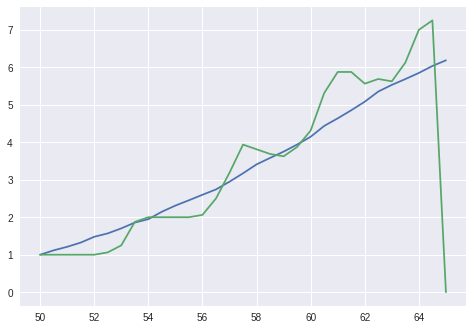

In [25]:
show_population_curve(bb.stats, REF, max_step=END_TIME)